# Coffe Shop Sales

O dataset escolhido para este trabalho contém informações de transações referente à uma cafeteria 
ficticia que opera em três locais de Nova York.

Disponível em: https://www.kaggle.com/datasets/ahmedabbas757/coffee-sales

## Característiscas do Dataset

Vamos ver a descrição de cada propriedade do dataset:

- <b>transaction_id</b> : ID sequencial exclusivo que representa uma transação individual

- <b>transaction_date</b> : Data da transação (MM/DD/AA)

- <b>transaction_time</b> : Carimbo de data/hora da transação (HH:MM:SS)

- <b>transaction_qty</b> : Quantidade de itens vendidos

- <b>store_id</b> : ID exclusivo da cafeteria onde a transação ocorreu

- <b>store_location</b> : Localização da cafeteria onde a transação ocorreu

- <b>product_id</b> : ID exclusivo do produto vendido

- <b>unit_price</b> : Preço de varejo do produto vendido

- <b>product_category</b> : Descrição da categoria do produto

- <b>product_type</b> : Descrição do tipo de produto

- <b>product_detail</b> : Descrição dos detalhes do produto



#### Fazendo download do dataset

In [2]:
#https://www.kaggle.com/datasets/ahmedabbas757/coffee-sales
# import kagglehub

# # Defina o caminho onde deseja salvar o dataset
# destination_path = "/home/kelvin/"  # Altere para o caminho desejado

# # Baixe o dataset na pasta especificada
# path = kagglehub.dataset_download("ahmedabbas757/coffee-sales")

# print("Path to dataset files:", path)


### Interpretando o dataset

In [3]:
import pandas as pd
dataframe = pd.read_excel("Coffee Shop Sales.xlsx")

In [4]:
dataframe.head()

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
2,3,2023-01-01,07:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg
3,4,2023-01-01,07:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm
4,5,2023-01-01,07:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg


In [5]:
print(dataframe.shape)

(149116, 11)


### Tamanho do dataset

149116 registros e 11 colunas

### Vamos ver agora a proporção de cada Classe

In [6]:
columns = dataframe.columns.to_list()
for col in columns:
    print(dataframe[col].value_counts(normalize=True) * 100)
    print("-----------")

transaction_id
149456    0.000671
1         0.000671
2         0.000671
3         0.000671
4         0.000671
            ...   
32        0.000671
33        0.000671
34        0.000671
35        0.000671
36        0.000671
Name: proportion, Length: 149116, dtype: float64
-----------
transaction_date
2023-06-19    0.900641
2023-06-16    0.892594
2023-06-18    0.865098
2023-06-13    0.859063
2023-06-27    0.856380
                ...   
2023-02-06    0.327933
2023-01-30    0.322568
2023-01-28    0.315191
2023-01-31    0.309826
2023-01-29    0.307814
Name: proportion, Length: 181, dtype: float64
-----------
transaction_time
09:31:15    0.027495
08:15:41    0.026825
08:19:08    0.025484
11:40:03    0.024142
10:11:25    0.024142
              ...   
14:21:29    0.000671
14:37:47    0.000671
16:49:24    0.000671
17:07:57    0.000671
12:48:24    0.000671
Name: proportion, Length: 25762, dtype: float64
-----------
transaction_qty
1    58.450468
2    39.326430
3     2.198959
4     0.015424
8  

Destaque especial para a classe transaction_qty.

### Onde há valores nulos?

In [7]:
print(dataframe.isnull().sum())

transaction_id      0
transaction_date    0
transaction_time    0
transaction_qty     0
store_id            0
store_location      0
product_id          0
unit_price          0
product_category    0
product_type        0
product_detail      0
dtype: int64


### Normalização dos dados

In [8]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Tratando as datas
dataframe["transaction_date"] = pd.to_datetime(dataframe["transaction_date"])
dataframe["Year"] = dataframe["transaction_date"].dt.year
dataframe["Month"] = dataframe["transaction_date"].dt.month
dataframe["Day"] = dataframe["transaction_date"].dt.day
dataframe.drop(columns=["transaction_date"], inplace=True)

# Tratando os horários para o formato cíclico (Seno/Cosseno)
dataframe["transaction_time"] = pd.to_datetime(dataframe["transaction_time"], format="%H:%M:%S")
dataframe["hour"] = dataframe["transaction_time"].dt.hour
dataframe["sin_hour"] = np.sin(2 * np.pi * dataframe["hour"] / 24)
dataframe["cos_hour"] = np.cos(2 * np.pi * dataframe["hour"] / 24)

#Dropando as colunas auxiliares / descartaveis de horas
# dataframe.drop(columns=["transaction_time", "hour"], inplace=True)


# Criando um label (ID) para os valores em string
label_encoder = LabelEncoder()
dataframe["store_location"] = label_encoder.fit_transform(dataframe["store_location"])
dataframe["product_category"] = label_encoder.fit_transform(dataframe["product_category"])
dataframe["product_type"] = label_encoder.fit_transform(dataframe["product_type"])
dataframe["product_detail"] = label_encoder.fit_transform(dataframe["product_detail"])

In [9]:
dataframe.head()

,transaction_id,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,Year,Month,Day,hour,sin_hour,cos_hour
0,1,1900-01-01 07:06:11,2,5,2,32,3.0,2,13,32,2023,1,1,7,0.965926,-0.258819
1,2,1900-01-01 07:08:56,2,5,2,57,3.1,8,4,71,2023,1,1,7,0.965926,-0.258819
2,3,1900-01-01 07:14:04,2,5,2,59,4.5,4,17,20,2023,1,1,7,0.965926,-0.258819
3,4,1900-01-01 07:20:24,1,5,2,22,2.0,2,10,60,2023,1,1,7,0.965926,-0.258819
4,5,1900-01-01 07:22:41,2,5,2,57,3.1,8,4,71,2023,1,1,7,0.965926,-0.258819


### O que vamos tentar prever?

Possíveis problemas:

- Existe um padrão de horário e quantidade de vendas em certas lojas?
- Há lojas ou produtos que têm padrões de vendas incomuns (outliers)?
- Os clientes seguem padrões de compras baseados em preço e quantidade?
- Há algum padrão nas transações?
- Existe um grupo de produtos frequentemente comprados juntos?


## Identificando Padrões
### Verificando os diferentes grupos de transações
Dado a categoria do produto, o tipo de produto, o preço unitário e a quantidade vendida, quais tipos de transações podemos identificar?

#### Padronizando os dados

In [10]:
from sklearn.preprocessing import StandardScaler

# Colunas a serem estudadas
features = ["product_category", "product_type", "unit_price", "transaction_qty"]
X = dataframe[features]

# Padronizando os dados
scaler = StandardScaler()
data_scaled = scaler.fit_transform(X)

#### KMEANS

In [11]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

kmeans = KMeans(n_clusters=3, random_state=0).fit(data_scaled)
kmeans.labels_

array([2, 2, 2, ..., 0, 0, 2], dtype=int32)

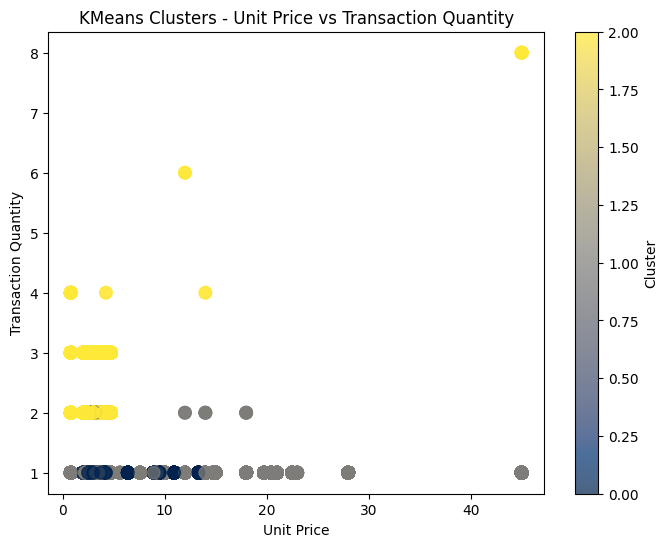

In [12]:
plt.figure(figsize=(8, 6))
# Selecionando duas colunas para plotar: unit_price e transaction_qty
scatter = plt.scatter(
  dataframe["unit_price"], 
  dataframe["transaction_qty"], 
  c=kmeans.labels_, 
  cmap='cividis', 
  s=80,
  alpha=0.7
)

plt.xlabel('Unit Price')
plt.ylabel('Transaction Quantity')
plt.title('KMeans Clusters - Unit Price vs Transaction Quantity')
plt.colorbar(scatter, label='Cluster')
plt.show()

Podemos observar no gráfico alguns outliers, como por exemplo uma transação de um produto com um valor alto em alta quantidade, o que não é comum!

### DBSCAN

In [13]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.15, min_samples=5)
clusters_dsbcan = dbscan.fit_predict(data_scaled)
unique_clusters = np.unique(clusters_dsbcan)
len(unique_clusters)

115

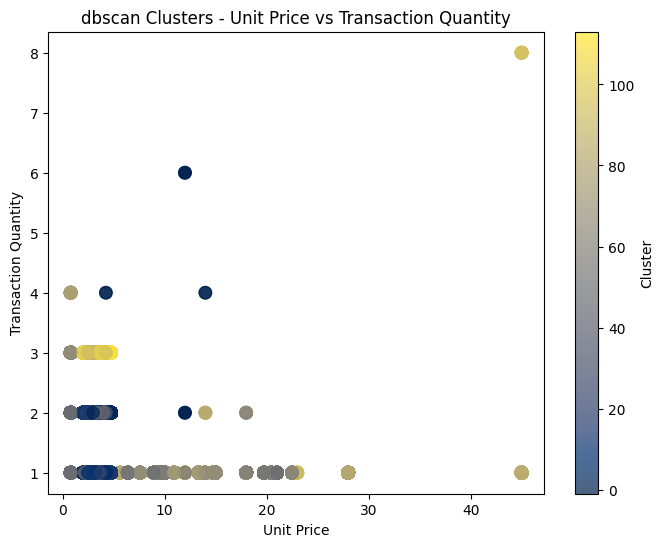

In [14]:
plt.figure(figsize=(8, 6))
# Selecionando duas colunas para plotar: unit_price e transaction_qty
scatter = plt.scatter(
  dataframe["unit_price"], 
  dataframe["transaction_qty"], 
  c=clusters_dsbcan, 
  cmap='cividis', 
  s=80,
  alpha=0.7
)

plt.xlabel('Unit Price')
plt.ylabel('Transaction Quantity')
plt.title('dbscan Clusters - Unit Price vs Transaction Quantity')
plt.colorbar(scatter, label='Cluster')
plt.show()

O dbscan identificou 115 tipo de clusters! Lembrando que o dataset possui um tamanho de 149 mil registros

Lembrando que, não foi feito nem um estudo para a definição do epsilon e do min_samples (Até o momento).

#### Hierárquico Aglomerativo

In [15]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage
frac = 0.1

n_samples = int(len(data_scaled) * frac)
random_indices = np.random.choice(len(data_scaled), n_samples, replace=False)
data_sample = data_scaled[random_indices]

agglo_cluster = AgglomerativeClustering(3)
agglo_cluster.fit(data_sample)
agglo_cluster.labels_

array([0, 0, 0, ..., 0, 1, 1])

Eu tive alguns problemas para executar o algoritmo aglomerativo.

1 - Tive que pegar apenas 10% dos dados, pois acontecia um erro de "Não foi possível alocar 81GB"

2 - Outra abordagem foi tentar convertar de float64 para float32, porém, sem sucesso.

In [16]:
# Calculando a matriz de ligação (Dendrograma)
#O método Ward tenta minimizar a variância dentro dos clusters ao fundi-los, 
# sendo útil para formar grupos compactos e homogêneos.
linked = linkage(data_sample, 'ward')

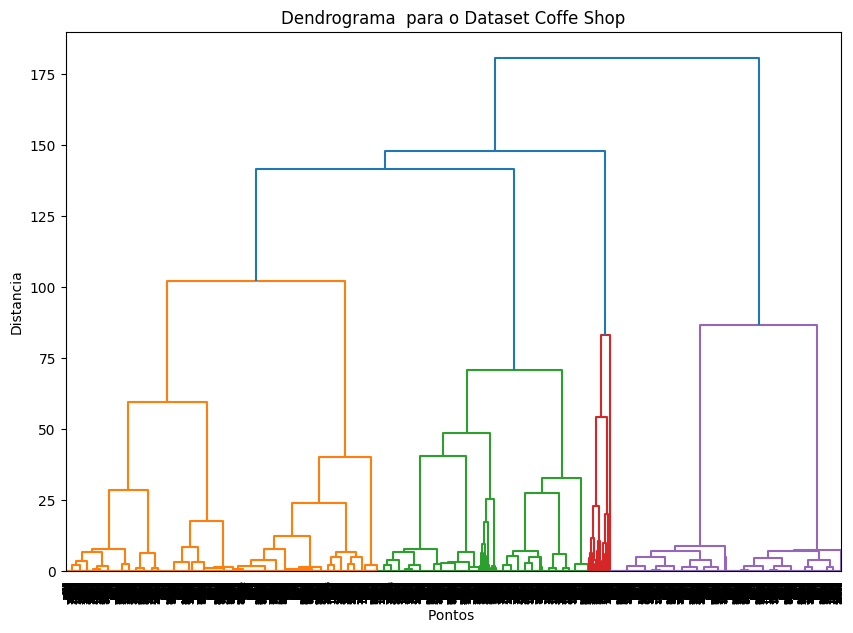

In [17]:
plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.title("Dendrograma  para o Dataset Coffe Shop")
plt.xlabel("Pontos ")
plt.ylabel("Distancia")
plt.show()

Olhando para o dendrograma atual treinado com 3 clusters, no momento, a melhor divisão aparenta ser com 4 grupos.

### Resumo da primeira parte

Utilizando valores sem se preocupar com os hiperparâmetros, chegamos a diferentes conclusões para cada algoritmo.

Para o KMeans foi utilizado um K = 3, o que não nos diz muita coisa dado que a escolha foi completamente arbitrária.

Para o DBSCAN, o mesmo encontrou um total de 115 grupos com o epsilon de 0.15 e min_samples de 5. Ou seja, com estes parâmetros temos 115 tipos grupos de transações? Vamos ver se com a otimização isso ainda faz sentido. 

Já o hierárquico aglomerativo, com o número de clusters = 3 (Lembrando que foi utilizado o "ward"), podemos identificar um corte de 4 grupos. Novamente, faz sentido? Temos uma discrepância muito grande do dbscan para o aglomerativo. 

Vamos ver se na próxima parte os algoritmos irão convergir para um ponto comum. 

### Métricas que poderão ser utilizadas para a avaliação dos algoritmos


- Método do Cotovelo (Elbow Method): O ponto onde a inércia para de diminuir significativamente é o melhor número de clusters.
    - Utilizado no KMeans.

- Silhouette Score: Quão bem os pontos estão agrupados dentro do cluster versus quão longe estão dos outros clusters.
    - Utilizado no KMeans, DBscan e Hierárquico.





# Parte 2

Nessa segunda parte do trabalho vamos otimizar os hiperparâmetros.

#### Utilizando o "Método do Cotovelo (Elbow Method)" para determinar o melhor valor de K

In [18]:
valores_k = []
inercias = []
for i in range(1, 100):
  kmeans = KMeans(n_clusters=i, random_state=0).fit(data_scaled)
  valores_k.append(i)
  inercias.append(kmeans.inertia_)

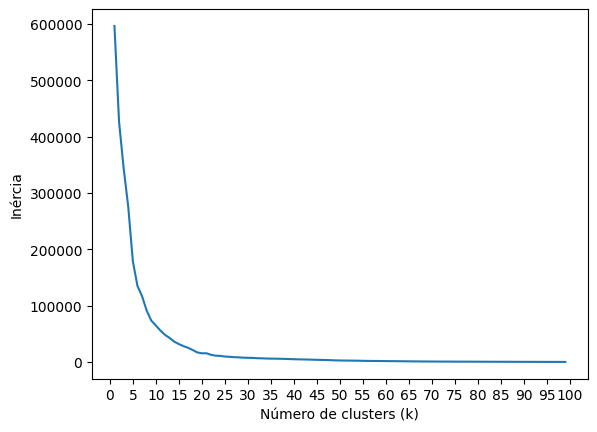

In [19]:
fig, ax = plt.subplots()
ax.plot(valores_k, inercias)
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inércia')
ax.set_xticks(range(0, max(valores_k) + 5, 5))
plt.show()

A inércia é a soma das distâncias quadradas dos pontos até o centro do seu cluster. Quanto menor, melhor (em geral), mas com mais clusters a inércia sempre tende a diminuir.

Olhando para o "cotovelo" do gráfico, podemos definir o melhor valor de K para algo em torno de 15 e 30.

Vamos testar!

In [20]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(data_scaled)
kmeans.labels_

array([2, 3, 2, ..., 5, 0, 2], dtype=int32)

### Não temos os rótulos verdadeiros!

E por conta disso não podemos usar o rand score :(

MAS, temos outra forma de verificar se a quantidade de clusters está nos dando bons resultados, a silhouette score!

## KMEANS

## Vamos plotar alguns gráficos para determinar o melhor valor de K

Por conta da demora em executar o código, decidi selecionar apenas 10% do dataset, o que equivale a 14911 amostras.

In [21]:
from sklearn.metrics import silhouette_score

#Redimensionando o dataset para 10%
frac = 0.1
n_samples = int(len(data_scaled) * frac)
random_indices_kmeans = np.random.choice(len(data_scaled), n_samples, replace=False)
data_sample_kmeans = data_scaled[random_indices_kmeans]

valores_k = []
silhouette_score_variation = []
# O silhouette score não permite k=1
for i in range(2, 30):
  kmeans = KMeans(n_clusters=i, random_state=0).fit(data_sample_kmeans)
  valores_k.append(i)
  silhouette_score_variation.append(silhouette_score(data_sample_kmeans, kmeans.labels_, metric="euclidean"))



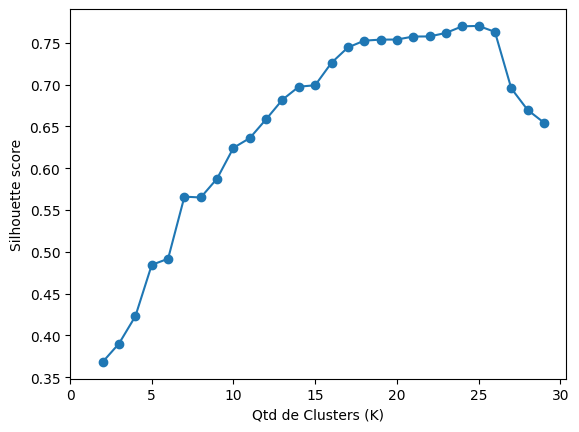

In [22]:
fig, ax = plt.subplots()
ax.plot(valores_k, silhouette_score_variation, marker='o')
plt.ylabel("Silhouette score")
plt.xlabel("Qtd de Clusters (K)")
ax.set_xticks(range(0, max(valores_k) + 5, 5))
plt.show()

Após amostra do gráfico, encontramos o melhor valor de K, sendo 25, do qual é maximizado a Silhouette Score!

Vamos aplicar no código!

In [23]:
kmeans = KMeans(n_clusters=25, random_state=0).fit(data_sample_kmeans)
kmeans.labels_

array([ 3,  4,  7, ..., 13,  1, 17], dtype=int32)

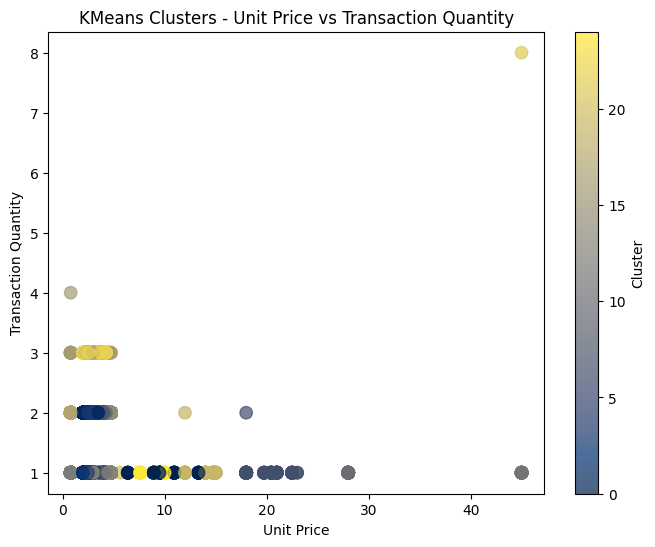

In [24]:
plt.figure(figsize=(8, 6))
# Selecionando duas colunas para plotar: unit_price e transaction_qty
scatter = plt.scatter(
  dataframe.loc[random_indices_kmeans, "unit_price"], 
  dataframe.loc[random_indices_kmeans, "transaction_qty"], 
  c=kmeans.labels_, 
  cmap='cividis', 
  s=80,
  alpha=0.7
)

plt.xlabel('Unit Price')
plt.ylabel('Transaction Quantity')
plt.title('KMeans Clusters - Unit Price vs Transaction Quantity')
plt.colorbar(scatter, label='Cluster')
plt.show()

Vamos verificar quantas transações há em cada tipo de cluster

In [25]:
labels = np.array(kmeans.labels_)
unicos, contagens = np.unique(labels, return_counts=True)

print("Contagem por cluster:")
for label, count in zip(unicos, contagens):
    print(f"Cluster {label}: {count} elementos")

Contagem por cluster:
Cluster 0: 97 elementos
Cluster 1: 1186 elementos
Cluster 2: 1285 elementos
Cluster 3: 2165 elementos
Cluster 4: 2291 elementos
Cluster 5: 781 elementos
Cluster 6: 98 elementos
Cluster 7: 815 elementos
Cluster 8: 834 elementos
Cluster 9: 738 elementos
Cluster 10: 29 elementos
Cluster 11: 16 elementos
Cluster 12: 326 elementos
Cluster 13: 597 elementos
Cluster 14: 573 elementos
Cluster 15: 800 elementos
Cluster 16: 71 elementos
Cluster 17: 347 elementos
Cluster 18: 132 elementos
Cluster 19: 82 elementos
Cluster 20: 905 elementos
Cluster 21: 1 elementos
Cluster 22: 124 elementos
Cluster 23: 544 elementos
Cluster 24: 74 elementos


## DBSCAN

Para maximizar a silhouette score do DBSCAN, vamos criar um range de testes para o epsilon e para o min_samples. 

Vamos também criar algumas funções auxiliares.

Para melhor otimização de tempo, vamos usar 10% dos dados do dataset, o que equivale à 14911.

In [26]:
def max_dbscan(X, eps_range, min_samples_range):
    best_score = -10
    best_eps = None
    best_samples = None

    # Vamos testar diferentes combinações, ou seja, loop dentro de lopp!
    for eps in eps_range:
        for min_sample in min_samples_range:
            dbscan = DBSCAN(eps=eps, min_samples=min_sample)
            labels_dbscan = dbscan.fit_predict(X)

            #Funcao "set" remove duplicatas
            if(len(set(labels_dbscan)) > 1):
                #Só podemos calcular o silhouete score se tiver mais de um cluster
                score = silhouette_score(X, labels_dbscan)

                if(score > best_score):
                    print(score, eps, min_sample)
                    best_score = score
                    best_eps = eps
                    best_samples = min_sample
    
    return best_score, best_eps, best_samples

#Vamos testar o eps de 0.1, até 5.0, de 0.1 em 0.1
eps_range = np.arange(0.5, 2.0, 0.3) 

#Vamos testar a quantidade de samples de 2 até 10
min_samples_range = range(3, 6) 

#Redimensionando o dataset para 10%
frac = 0.1
n_samples = int(len(data_scaled) * frac)
random_indices_dbscan = np.random.choice(len(data_scaled), n_samples, replace=False)
data_sample_dbscan = data_scaled[random_indices_dbscan]
print(max_dbscan(data_sample_dbscan, eps_range, min_samples_range))

0.7619069564245966 0.5 3
(np.float64(0.7619069564245966), np.float64(0.5), 3)


No passo anterior não plotamos o gráfico, mas retornamos os melhores valores de cada hiperparâmetro!

In [48]:
eps = 0.5 #@param
min_sample = 3 #@param
dbscan = DBSCAN(eps=eps, min_samples=min_sample)
clusters_dsbcan = dbscan.fit_predict(data_sample_dbscan)

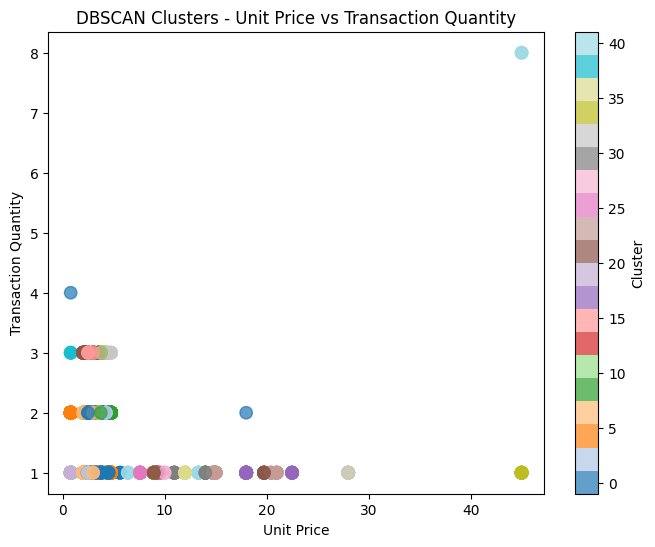

In [49]:
plt.figure(figsize=(8, 6))
# Selecionando duas colunas para plotar: unit_price e transaction_qty
scatter = plt.scatter(
  dataframe.loc[random_indices_dbscan, "unit_price"], 
  dataframe.loc[random_indices_dbscan, "transaction_qty"], 
  c=clusters_dsbcan, 
  cmap='tab20', 
  s=80,
  alpha=0.7
)

plt.xlabel('Unit Price')
plt.ylabel('Transaction Quantity')
plt.title('DBSCAN Clusters - Unit Price vs Transaction Quantity')
plt.colorbar(scatter, label='Cluster')
plt.show()

Através dos hiperparâmetros encontrados, vemos que o nosso DBSCAN encontrou 40 tipos de categorias de transações, o que é relativamente maior se comparado com os 25 clusters encontrados no KMeans.

Vamos verificar quantas transações há em cada tipo de cluster

In [32]:
labels = np.array(clusters_dsbcan)
unicos, contagens = np.unique(labels, return_counts=True)

print("Contagem por cluster:")
for label, count in zip(unicos, contagens):
    print(f"Cluster {label}: {count} elementos")

Contagem por cluster:
Cluster -1: 2 elementos
Cluster 0: 2147 elementos
Cluster 1: 1625 elementos
Cluster 2: 740 elementos
Cluster 3: 2212 elementos
Cluster 4: 634 elementos
Cluster 5: 361 elementos
Cluster 6: 1285 elementos
Cluster 7: 1158 elementos
Cluster 8: 564 elementos
Cluster 9: 862 elementos
Cluster 10: 838 elementos
Cluster 11: 34 elementos
Cluster 12: 860 elementos
Cluster 13: 44 elementos
Cluster 14: 577 elementos
Cluster 15: 141 elementos
Cluster 16: 13 elementos
Cluster 17: 37 elementos
Cluster 18: 318 elementos
Cluster 19: 28 elementos
Cluster 20: 69 elementos
Cluster 21: 41 elementos
Cluster 22: 16 elementos
Cluster 23: 42 elementos
Cluster 24: 22 elementos
Cluster 25: 27 elementos
Cluster 26: 24 elementos
Cluster 27: 10 elementos
Cluster 28: 4 elementos
Cluster 29: 20 elementos
Cluster 30: 13 elementos
Cluster 31: 19 elementos
Cluster 32: 25 elementos
Cluster 33: 15 elementos
Cluster 34: 25 elementos
Cluster 35: 21 elementos
Cluster 36: 4 elementos
Cluster 37: 4 element

Como podemos ver, há clusters setados como -1, ou seja, são nossos outliers!

## Hierarquico Aglomerativo

De forma semelhante, vamos também reduzir o volume dos dados para 10%.

Lembrando que mesmo na Parte 1 não foi possível executar o respectivo algoritmo com todos os dados.

In [ ]:
frac = 0.1

n_samples = int(len(data_scaled) * frac)
random_indices = np.random.choice(len(data_scaled), n_samples, replace=False)
data_sample_agglo = data_scaled[random_indices]

valores_k_agglo = []
silhouette_score_variation_agglo = []
# O silhouette score não permite k=1
for i in range(2, 50):
  agglo_cluster = AgglomerativeClustering(i).fit(data_sample_agglo)
  valores_k_agglo.append(i)
  silhouette_score_variation_agglo.append(
    silhouette_score(data_sample_agglo, agglo_cluster.labels_, metric="euclidean")
  )

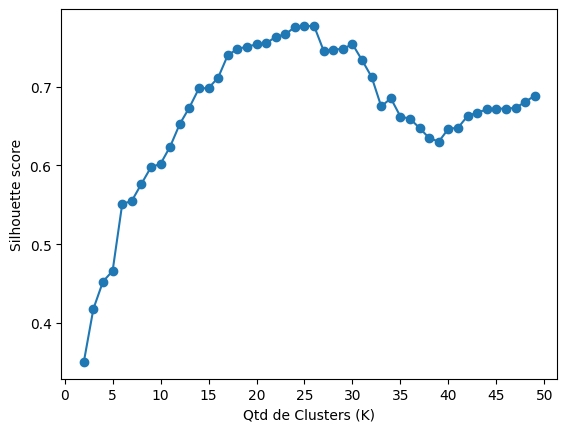

In [36]:
fig, ax = plt.subplots()
ax.plot(valores_k_agglo, silhouette_score_variation_agglo, marker='o')
plt.ylabel("Silhouette score")
plt.xlabel("Qtd de Clusters (K)")
ax.set_xticks(range(0, max(valores_k_agglo) + 5, 5))
plt.show()

Como podemos ver através do gráfico da Silhouette Score para o Hierárquivo Aglomerativo, o melhor valor para o cluster é 25!

Vamos aplicar no código.

In [42]:
agglo_cluster = AgglomerativeClustering(25)
agglo_cluster.fit(data_sample_agglo)
agglo_cluster.labels_

array([ 1,  9,  6, ..., 10, 23,  5])

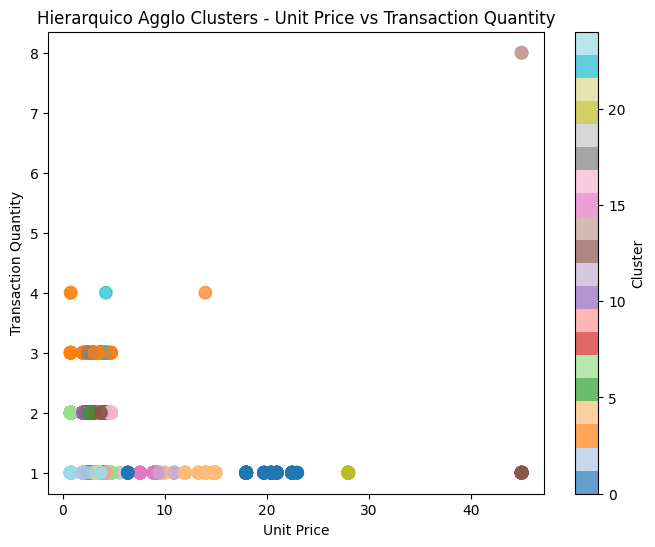

In [43]:
plt.figure(figsize=(8, 6))
# Selecionando duas colunas para plotar: unit_price e transaction_qty
scatter = plt.scatter(
  dataframe.loc[random_indices, "unit_price"], 
  dataframe.loc[random_indices, "transaction_qty"], 
  c=agglo_cluster.labels_, 
  cmap='tab20', 
  s=80,
  alpha=0.7
)

plt.xlabel('Unit Price')
plt.ylabel('Transaction Quantity')
plt.title('Hierarquico Agglo Clusters - Unit Price vs Transaction Quantity')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [44]:
labels = np.array(agglo_cluster.labels_)
unicos, contagens = np.unique(labels, return_counts=True)

print("Contagem por cluster:")
for label, count in zip(unicos, contagens):
    print(f"Cluster {label}: {count} elementos")

Contagem por cluster:
Cluster 0: 130 elementos
Cluster 1: 2292 elementos
Cluster 2: 1250 elementos
Cluster 3: 139 elementos
Cluster 4: 111 elementos
Cluster 5: 2154 elementos
Cluster 6: 359 elementos
Cluster 7: 552 elementos
Cluster 8: 825 elementos
Cluster 9: 814 elementos
Cluster 10: 1191 elementos
Cluster 11: 71 elementos
Cluster 12: 759 elementos
Cluster 13: 20 elementos
Cluster 14: 3 elementos
Cluster 15: 71 elementos
Cluster 16: 545 elementos
Cluster 17: 120 elementos
Cluster 18: 854 elementos
Cluster 19: 954 elementos
Cluster 20: 18 elementos
Cluster 21: 564 elementos
Cluster 22: 55 elementos
Cluster 23: 729 elementos
Cluster 24: 331 elementos


Vamos então visualizar o Dendrograma!

In [40]:
linked = linkage(data_sample_agglo, 'ward')

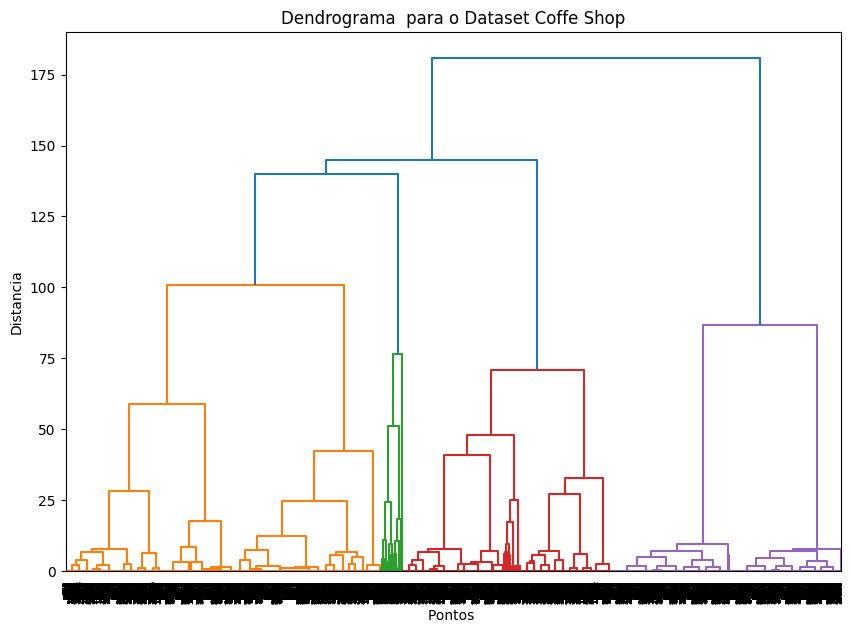

In [47]:
plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.title("Dendrograma  para o Dataset Coffe Shop")
plt.xlabel("Pontos ")
plt.ylabel("Distancia")
# plt.axhline(y=60, color='r', linestyle='--')
plt.show()

### Diferenças do Dendrograma para o Silhouette Score!

Depois da seleção dos hiperparâmetro do Hierárquico Aglomerativo, chegamos na melhor configuração de 25 clusters, enquanto se olharmos para o dendrograma, veremos que o melhor corte pode ser feito em ~=60, o que nos daria cerca de 4 clusters!

Mas porque essa diferença?

A silhouette score sempre tenta nos dar a melhor separação dos grupos com base matematica, enquanto o dendrograma exige uma intertepretação!

Então qual o melhor? DEPENDE!

Tudo depende do problema que estamos tentando lidar.

Neste exemplo, caso o dono das cafeterias queira maximizar a categoria de clientes e para isso, criar promoções para os respectivos grupos, usará a informação do Hierárquico Aglomerativo, ou caso ele queira criar poucas promoções para um pequeno grupo de clientes (lembrando, com base nas transações), pode usar o dendrograma!

## KMeans x DBSCAn x Hierárquico Aglomerativo/Dendrograma

O KMeans encontrou ~=25 grupos de transações, o DBSCAN 40 e o hierarquico também 25.

Olhando para o Dendrograma, dividmos em cerca de 4 clusters!

Mas eai, qual escolher?

Como o nosso problema não é rotulado, os algoritmos servem de guia para o problema de negócio!

Conforme dito na sessão anterior, tudo depende do que estamos tentando lidar, de qual problema estamos tentando resolver!

Nestes exemplos usamos apenas as colunas: ["product_category", "product_type", "unit_price", "transaction_qty"]



# Usando todos os dados do dataframe!

Nos exemplos anteriores, para fins de otimização, foi usado apenas 4 colunas, pois estávamos tentando encontrar uma divisão das transações!

E se formos usar todo o dataframe? Para isso, precisamos reduzir a dimensionalidade do algoritmo de forma eficaz!

## PCA

Vamos olhar novamente para o nosso dataframe

In [51]:
dataframe.head()

,transaction_id,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,Year,Month,Day,hour,sin_hour,cos_hour
0,1,1900-01-01 07:06:11,2,5,2,32,3.0,2,13,32,2023,1,1,7,0.965926,-0.258819
1,2,1900-01-01 07:08:56,2,5,2,57,3.1,8,4,71,2023,1,1,7,0.965926,-0.258819
2,3,1900-01-01 07:14:04,2,5,2,59,4.5,4,17,20,2023,1,1,7,0.965926,-0.258819
3,4,1900-01-01 07:20:24,1,5,2,22,2.0,2,10,60,2023,1,1,7,0.965926,-0.258819
4,5,1900-01-01 07:22:41,2,5,2,57,3.1,8,4,71,2023,1,1,7,0.965926,-0.258819


In [61]:
# Lembrando que tem mais colunas do que o original devido ao tratamento dos dados
dataframe.shape

(149116, 14)

Na parte 1 foi tratado os dados, porém, como escolhemos a dedo as colunas para se trabalhar até então, não foi necessários remove-los.

Vamos remover as colunas auxiliares: transaction_time e hour

In [52]:
dataframe.drop(columns=["transaction_time", "hour"], inplace=True)

E vamos padronizar todos os dados!

In [53]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dataframe)

Primeiro, vamos executar o PCA sem definir o número de componentes.

In [56]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_scaled)
pca.explained_variance_ratio_

array([0.15332327, 0.14305266, 0.11520596, 0.09294398, 0.08985828,
       0.08254102, 0.07766697, 0.06018772, 0.0574506 , 0.04901031,
       0.04373996, 0.03418661, 0.00083265, 0.        ])

Vamos somar os X primeiros elementos do PCA.

In [59]:
print(sum(pca.explained_variance_ratio_[:7]))

0.7545921455919821


Mas a partir de que ponto o ganho de dados é quase nulo? Vamos olhar o gráfico!

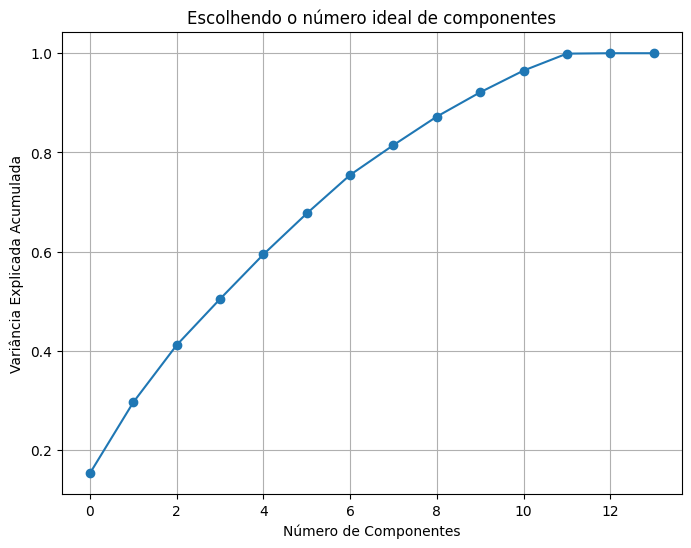

In [62]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Escolhendo o número ideal de componentes')
plt.grid(True)
plt.show()

Olhando para o gráfico, vemos que a partir de 10 componentes o ganho é quase nulo, mas isso não nos ajuda em nada!

O objetivo é reduzir o número de componentes para uma melhor otimização, então, vamos aceitar uma explicação dos dados de 80%, o que nos dá aproximadamente 7 componentes!

In [63]:
pca = PCA(n_components=7)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

Vamos também utilizar o kmeans para extrair as labels (Levando em consideração a quantidade de clusters da parte anterior, 25)

In [70]:
kmeans = KMeans(n_clusters=25, random_state=0).fit(X_pca)
kmeans.labels_

array([ 3, 23,  3, ..., 14,  7,  7], dtype=int32)

Junto com o PCA e o KMEANS, vamos plotar os gráficos!

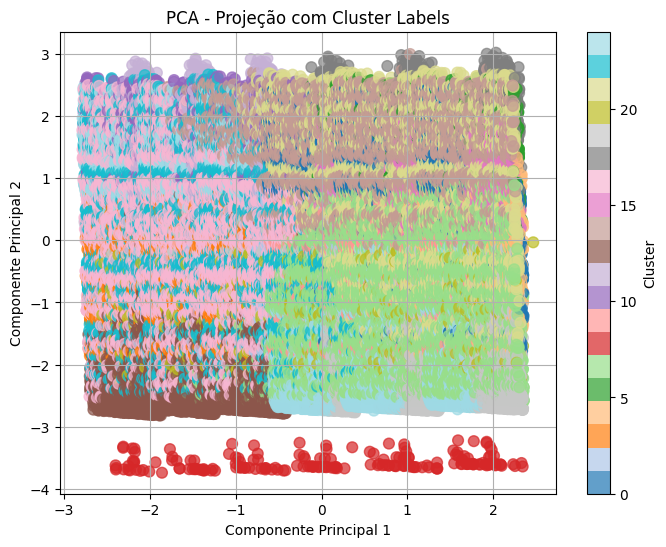

In [72]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='tab20', s=60, alpha=0.7)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA - Projeção com Cluster Labels')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

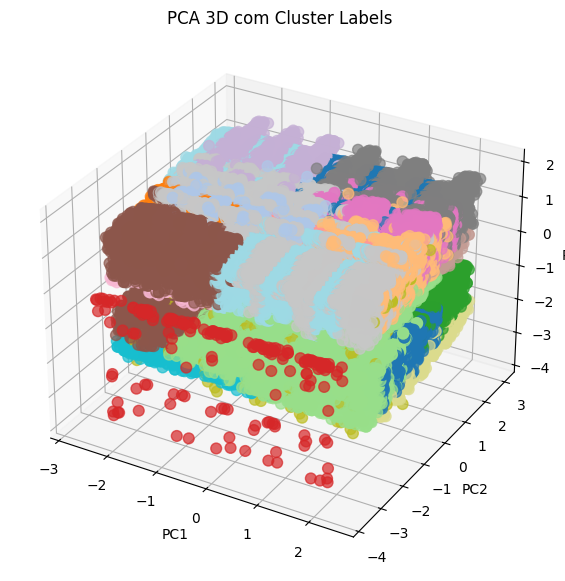

In [74]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=kmeans.labels_, cmap='tab20', s=60, alpha=0.7)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('PCA 3D com Cluster Labels')
plt.show()

Um caos?! Talvez? E se diminuirmos a quantidade de clusters no kmeans?

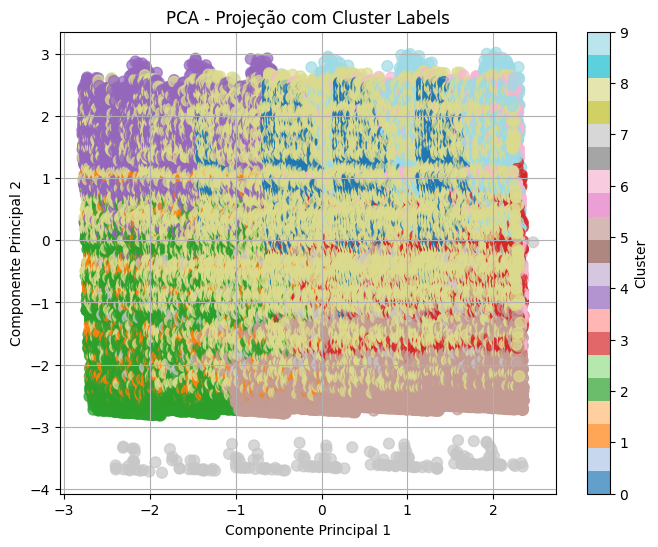

In [77]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_pca)
kmeans.labels_

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='tab20', s=60, alpha=0.7)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA - Projeção com Cluster Labels')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()


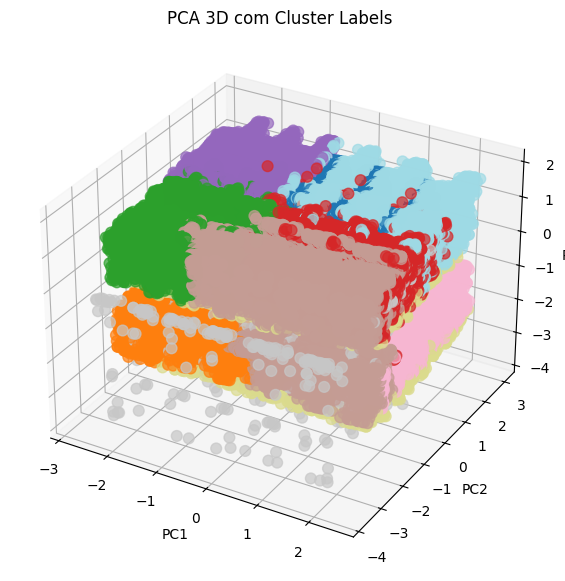

In [78]:

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=kmeans.labels_, cmap='tab20', s=60, alpha=0.7)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('PCA 3D com Cluster Labels')
plt.show()